# 가장 좋은 결과를 낼 수 있는 feature항목 추출

## 모든 feature를 사용한 결과와, 선택 추출된 feature만 사용한 결과 정확도에 차이가 남
#### logistic 회귀 이용하여 coef_ 항목에서 영향력이 높은 feature를 선택. 최적의 갯수 선택

### 데이터 준비하기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
# 로지스틱회귀후에 .coef_ 항목에서 기준(criteria, 계수)보다 높은 영향력을 미치는 feature column 선택
def select_features(df, coef, criteria):
    sel_num = np.where(np.abs(coef) > criteria )[1]
    sel_col = df.columns[sel_num]
    return sel_col

In [3]:
def get_scores(data, target):
    train_input, test_input, train_target, test_target = train_test_split(data, target, random_state=42, test_size=0.2, stratify=target)

    ss = StandardScaler()
    ss.fit(train_input)
    train_scaled = ss.transform(train_input)
    test_scaled = ss.transform(test_input)

    lr = LogisticRegression(C=20, max_iter=4000) # max_iter default 100, 
#     lr = LogisticRegression(C=1, solver='newton_cg', max_iter=1000) # max_iter default 100, 
    lr.fit(train_scaled, train_target)

    train_score = lr.score(train_scaled, train_target)
    test_score = lr.score(test_scaled, test_target)
#     print(f'train score: {train_score:.4f} \n test score; {test_score:.4f}')
    return train_score, test_score, lr.coef_, lr.intercept_

In [4]:
def find_best_result(data, target):
# min을 하나씩 제거하면서 최고의 결과를 가져오는 feature갯수(항목) 선택

    train_score_list= []
    test_score_list = []
#     data_columns = []
#     data_coef = []
    test_s = 0
    train_score, test_score, coef, intercept = get_scores(data, target)
    for _ in range(len(data.columns)-1):
        criteria = np.abs(coef).min()
        sel_col = select_features(data, coef, criteria)
        data = df[sel_col]
        train_score, test_score, coef, intercept = get_scores(data, target)

        if test_score > test_s:
            test_s = test_score
            data_columns = sel_col
            data_coef = coef

        train_score_list.append(train_score)
        test_score_list.append(test_score)
    
    return train_score_list, test_score_list, data_columns, data_coef

In [5]:
# 분석용 데이터 입력
directory_for_ml = '../data/data_for_ml/'
fname = 'df_sec_sel.pkl'
f_name = directory_for_ml + fname
df = pd.read_pickle(f_name)
plt_title = fname[3:7]

In [6]:
data = df.iloc[:, :-3]

# target = df.iloc[:, -1]
# plt_title2 = 'r_open_high'

target = df.iloc[:, -2]
plt_title2 = 'close_cr'

In [7]:
train_score_list, test_score_list, data_columns, data_coef = find_best_result(data, target)

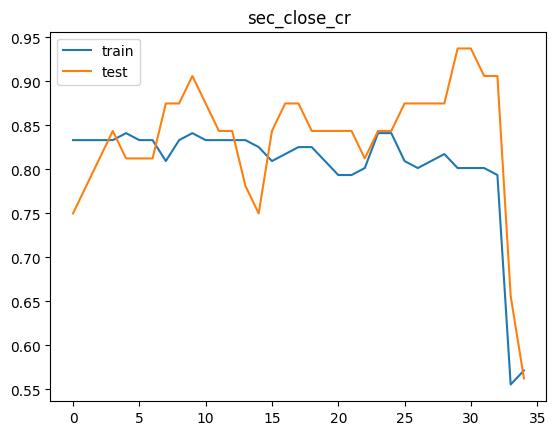

In [8]:
plt.plot(train_score_list, label = 'train')
plt.plot(test_score_list, label = 'test')
plt.title(plt_title+plt_title2)
plt.legend()

In [9]:
print(data_columns, data_coef)
print("train_max: {:.4f}, test_max: {:.4f}".format(max(train_score_list), max(test_score_list)))

Index(['dji_cr', 'ixic_cr', 'ixic_f_cr', 'spx_f_cr', 'kosdaq_cr', 'kospi_cr'], dtype='object') [[-1.21714957 -2.10765869  2.21882822  1.24344733 -0.85732388  2.99109488]]
train_max: 0.8413, test_max: 0.9375


In [10]:
data_columns.shape

(6,)

In [11]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_validate, train_test_split
from tensorflow import keras
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split

In [12]:
data_new = data[data_columns]
# target = df.iloc[:, -2]  # logistic regression에서 생성된 target을 그대로 사용

In [13]:
data_new.tail()

,dji_cr,ixic_cr,ixic_f_cr,spx_f_cr,kosdaq_cr,kospi_cr
2023-02-15,0.11,0.92,0.78,0.31,-1.81,-1.53
2023-02-16,-1.27,-1.78,-1.94,-1.41,2.51,1.96
2023-02-17,0.39,-0.58,-0.74,-0.30,-1.16,-0.98
2023-02-21,-2.06,-2.50,-2.28,-1.74,0.57,0.16
2023-02-22,-0.25,0.13,0.01,-0.17,-1.88,-1.68


In [14]:
train_input, test_input, train_target, test_target = train_test_split(data_new, target, random_state=42, test_size=0.2, stratify=target)

In [15]:
print(train_input.shape, train_target.shape)

(126, 6) (126,)


In [16]:
np.unique(train_target, return_counts=True)

(array([0, 1], dtype=int64), array([65, 61], dtype=int64))

In [17]:
ss = StandardScaler()
ss.fit(train_input)
train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)

In [18]:
value = []
for iter in range(5, 50, 1):
    sc = SGDClassifier(loss='log', max_iter=iter, random_state=42)
#     sc = SGDClassifier(max_iter=iter, random_state=42)
    scores = cross_validate(sc,
                            X=train_scaled, y=train_target,
                            n_jobs=-1)
#     print(scores['test_score'].mean())
    value.append(scores['test_score'].mean())

In [19]:
print("max", max(value))

max 0.8252307692307692


In [20]:
!rm *.h5

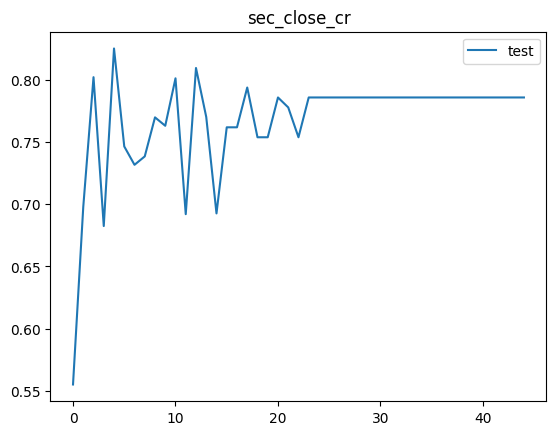

In [21]:
plt.plot(value, label = 'test')
plt.title(plt_title+plt_title2)
plt.legend()

### 인공신경망

In [35]:
def model_fn(inp_num, a_layer=None):
    model = Sequential()
    model.add(Dense(12, activation='sigmoid', input_shape=(inp_num,)))
#     model.add(Dropout(0.3))
    model.add(Dense(6, activation='sigmoid'))
#     model.add(Dropout(0.3))
    if a_layer:
        model.add(a_layer)
    model.add(Dense(1, activation='sigmoid'))
    
    return model

In [36]:
# model = model_fn(10, len(data_new.columns), 2, Dropout(0.3))
try :
    del model
    print("delete del")
except:
    pass
model = model_fn(len(data_new.columns))
model.compile(optimizer='adam', loss='binary_crossentropy', 
              metrics=['accuracy'])
model.summary()

delete del
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 12)                84        
                                                                 
 dense_4 (Dense)             (None, 6)                 78        
                                                                 
 dense_5 (Dense)             (None, 1)                 7         
                                                                 
Total params: 169
Trainable params: 169
Non-trainable params: 0
_________________________________________________________________


In [37]:
# checkpoint_cb = ModelCheckpoint('best_model.h5', save_best_only=True)
# checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath='best_model_{epoch:02d}-{val_loss:.2f}-{val_accuracy:.2f}.h5', \
#                                                 monitor='val_accuracy', mode='max', save_best_only=True)
checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath='best_model.h5', save_best_only=True)
earlystopping_cb = keras.callbacks.EarlyStopping(patience=100, monitor='val_accuracy', mode='max', restore_best_weights=True)

In [38]:
np.unique(train_target), np.unique(test_target)

(array([0, 1], dtype=int64), array([0, 1], dtype=int64))

In [39]:
history = model.fit(train_scaled, train_target, epochs=2000, verbose=0,
                    callbacks=[checkpoint_cb, earlystopping_cb],
                    validation_data=(test_scaled, test_target))
# batch_size=

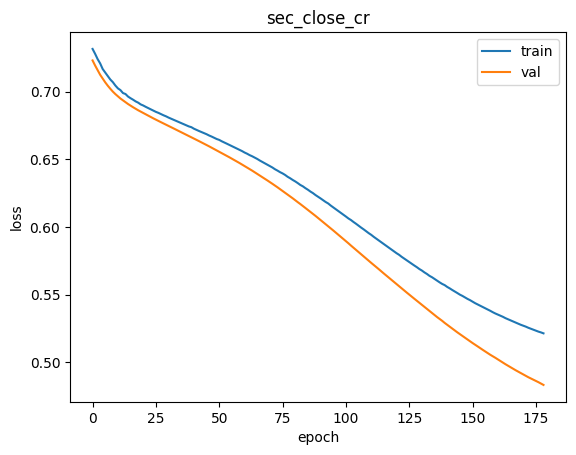

In [40]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.title(plt_title+plt_title2)
plt.show()

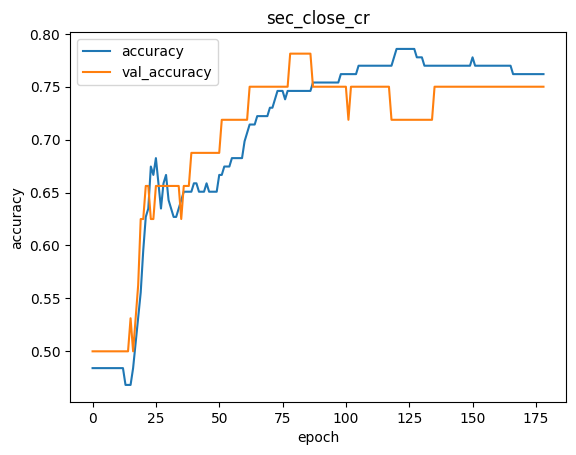

In [41]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.title(plt_title+plt_title2)
plt.show()

In [42]:
earlystopping_cb.stopped_epoch

178

In [43]:
model.evaluate(test_scaled, test_target)

1/1 [==============================] - 0s 18ms/step - loss: 0.6226 - accuracy: 0.7812


[0.6226394772529602, 0.78125]

In [45]:
!rm best_*.*

In [46]:
model_val = load_model('best_model.h5')
model_val.evaluate(test_scaled, test_target)

OSError: No file or directory found at best_model.h5

In [ ]:
len(test_target)

In [47]:
test_scaled

array([[-3.81229727e-01, -5.61932854e-01, -6.44572925e-01,
        -5.26761635e-01,  7.01116790e-01,  9.64536516e-01],
       [-6.62634522e-01, -1.02455710e+00, -1.05296811e+00,
        -8.56044469e-01, -2.92196074e-03,  3.33840590e-01],
       [-1.96732948e+00, -1.77356779e+00, -1.85342266e+00,
        -1.82241800e+00, -5.84238361e-01, -1.40933287e+00],
       [-6.71161940e-01, -5.56425423e-01, -5.02995929e-01,
        -6.84244729e-01,  3.58786021e-01, -8.66233602e-02],
       [ 1.34130871e+00,  1.59698030e+00,  1.52264418e+00,
         1.47041034e+00, -1.05575055e+00, -7.96156277e-01],
       [ 6.25005598e-01,  9.74640540e-01,  9.50890920e-01,
         8.83427893e-01,  1.25013783e+00,  2.98801928e-01],
       [ 1.77620703e+00,  9.91162834e-01,  9.83562535e-01,
         1.34156053e+00, -3.32334587e-01,  3.16321259e-01],
       [-2.70373293e-01,  2.31137285e-01,  2.43005938e-01,
        -8.29456414e-02,  7.52789359e-01,  4.03917915e-01],
       [-4.75031326e-01, -6.83096348e-01, -6.445

In [48]:
y_predict = model.predict(np.array(test_scaled))

1/1 [==============================] - 0s 34ms/step


In [118]:
y_predict_list = [1 if i > 0.5 else 0 for i in y_predict[:, 0]]

In [120]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_target, y_predict_list)

array([[15,  1],
       [ 6, 10]], dtype=int64)

In [121]:
from sklearn.metrics import precision_score, recall_score
# 정밀도
precision_score(test_target, y_predict_list)  # 정밀도, 입력값의 순서 중요힘. (실제값, 예측값)

0.9090909090909091

In [122]:
# 재현율
recall_score(test_target, y_predict_list)  # 재현율, 입력값의 순서 중요힘. (실제값, 예측값)

0.625

In [123]:
from sklearn.metrics import f1_score

f1_score(test_target, y_predict_list)

0.7407407407407406

In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

In [ ]:
for innum in range(30):
    aa = np.array([test_scaled[innum]])
    y_predict = model.predict(aa)
    print("predict: {},  target_value: {}".format(y_predict, test_target[innum]))

In [ ]:
### ROC 확인해 봐야 함. 정확도, 정밀도 등

In [ ]:
y_predict, test_target[innum]

In [ ]:
test_scaled.shape

In [ ]:
aa = np.array([test_scaled[10]])

In [ ]:
test_scaled[5]

In [ ]:
'''
model.save('my_model.h5')
model_new = load_model('my_model.h5')
model_new.evaluate(test_scaled, test_target)
'''